# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding**

---

## Step 1: Camera calibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

# prepare object points
# number of chessboard inside corners in x
nx = 9
# number of chessboard inside corners in y
ny = 6

images = glob.glob('camera_cal/calibration*.jpg')

# 3D points in real word space
imgpoints = [] 
# 2D points in image plane
objpoints = [] 

# prepare object points, like (0,0,0), (1,0,0), (2,0,0)...(9,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coordinate

for fname in images: 
    # read in each image
    img = cv2.imread(fname)
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
   
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

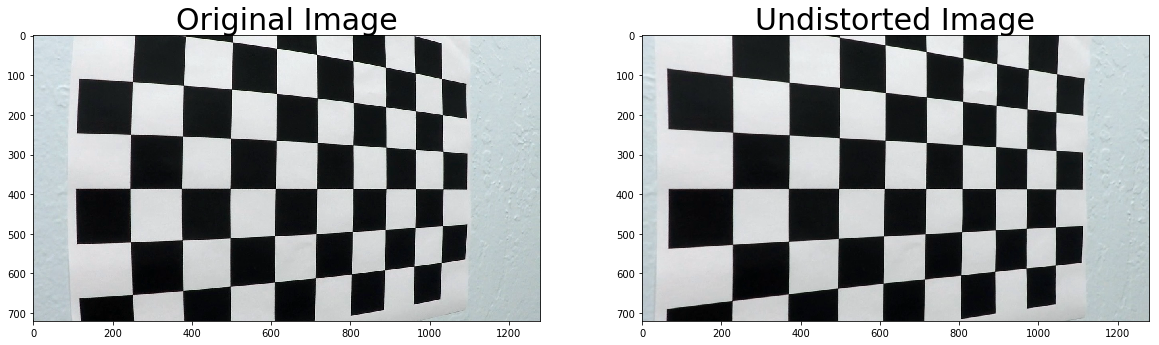

In [2]:
import pickle

def save_cal_result(mtx, dist):
    cal_pickle = {}
    cal_pickle["mtx"] = mtx
    cal_pickle["dist"] = dist
    # save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    pickle.dump( cal_pickle, open( "camera_cal/cal_pickle.p", "wb" ) )

def cal_undistort(img, objpoints, imgpoints):
    image_size = (img.shape[1],img.shape[0])
    # take object points, and image points and 
    # calculate camera matrix, distortion coefficients, rotation and translation vectors
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
    # then undistort the image with camera matrix and distortion coefficients
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # next save the camera matrix and distortion coefficient for further usage
    save_cal_result(mtx,dist)
    return undist

test_file = 'camera_cal/test_calibration5.jpg'
distorted = cv2.imread(test_file)

undistorted = cal_undistort(distorted, objpoints, imgpoints)       

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(distorted)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)

In [3]:
## Step 2: Distortion correction

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

def undistort_img(img, mtx, dist): 
    return cv2.undistort(img, mtx, dist, None, mtx)

def undistort_road_img(img):
    dist_pickle = pickle.load( open( "camera_cal/cal_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    return undistort_img(img, mtx, dist)

In [5]:
## Step 3: Color & gradient threshold

In [6]:
def compute_binary(img, thresh):
    binary_output = np.zeros_like(img)
    binary_output[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

def get_channel(img, channel_no=0, conv=cv2.COLOR_RGB2HLS):
    color_space = cv2.cvtColor(img, conv).astype(np.float).astype(np.float)
    return color_space[:,:,channel_no]

def compute_sobel_binary(img, channel_no=0, sobel_kernel=3, orient='x', conv=cv2.COLOR_RGB2HLS, thresh=(0,255)):
    l_channel = get_channel(img, channel_no, conv)
    
    if orient == 'x':
        sobel = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    if orient == 'y':
        sobel = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in x

    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobel = np.absolute(sobel) 
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Threshold x gradient
    return compute_binary(scaled_sobel, thresh)

def compute_color_binary(img, channel_no=0, conv=cv2.COLOR_RGB2HLS, thresh=(0,255)):
    s_channel = get_channel(img, 2, conv) 
    # Threshold color channel
    return compute_binary(s_channel, thresh)

def compute_combined_3_binaries(img1, img2, img3):
    combined_binary = np.zeros_like(img1)
    combined_binary[(img1 == 1) | (img2 == 1) | (img3 == 1)] = 1
    return combined_binary

def compute_stack_3_binaries(img1, img2, img3 ):
    return np.dstack(( np.zeros_like(img1), img1, img2, img3))

def thresh_road_img(img, s_thresh=(170, 255), sx_thresh=(90, 150), v_thresh=(220,255)):
    sx_binary = compute_sobel_binary(img, 1, 3, 'x', cv2.COLOR_RGB2HLS, sx_thresh)
    s_binary = compute_color_binary(img, 2, cv2.COLOR_RGB2HLS, s_thresh)
    v_binary = compute_color_binary(img, 2, cv2.COLOR_RGB2HSV, v_thresh)
    color_binary = compute_stack_3_binaries(sx_binary, s_binary, v_binary)
    combined_binary = compute_combined_3_binaries(sx_binary, s_binary, v_binary)
    return combined_binary


In [7]:
## Step 4: Perspective transform 

In [8]:
def warp_img(img, src_coords, dst_coords, matrix_transform='True'):
    img_size = (img.shape[1], img.shape[0])
    if matrix_transform == 'True':
        # if True compute matrix transform
        M = cv2.getPerspectiveTransform(src_coords, dst_coords)
    else:
        # if False compute inverse matrix transform
        M = cv2.getPerspectiveTransform(dst_coords, src_coords)
    
    # create warped image with linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M

def warp_road_img(img, to_bird_eye_view='True'):
    # define source and destination coordinates
    src = np.float32([[214,720], [580,460], [704,460], [1086,720]])
    offset = [50,0]
    
    _top_left=np.array([src[0,0],0])
    _top_right=np.array([src[3,0],0])
    
    dst = np.float32([src[0]+offset, _top_left+offset, _top_right-offset, src[3]-offset])
    return warp_img(img, src, dst, to_bird_eye_view)

In [65]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


def draw_road_window(ima):
    pts = np.array([[214,720], [580,460], [704,460], [1086,720]], np.int32)
    pts = pts.reshape((-1,1,2))
    return cv2.polylines(ima,[pts],True,(0,255,255))



def search_sliding_window(binary_warped):
    #binary_warped = np.copy(img)
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return out_img, left_lane_inds, right_lane_inds, left_fit, right_fit


def search_margin(binary_warped, left_lane_inds, right_lane_inds):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ##########
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #######
    
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx
   

def draw_sliding_window(binary_warped, out_img, left_lane_inds, right_lane_inds):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    print (left_lane_inds, nonzeroy[left_lane_inds], nonzerox[left_lane_inds])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    mpimg.imsave("output_images/pipeline_result.jpg", out_img, cmap='gray')

    
    
def mark_road(img, binary_warped):
    #color_warped = np.zeros_like(img)
    color_undist = undistort_road_img(img)
    color_warped_output, M = warp_road_img(color_undist, False)

    outimg, left_ind, right_ind, left_fit, right_fit = search_sliding_window(binary_warped)
    left_fitx, right_fitx = search_margin(binary_warped, left_ind, right_ind)
    #draw_sliding_window(img, outimg, left_ind, right_ind)
    #draw_sliding_window(img, left, right)

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((left_line, right_line))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(window_img, M, (img.shape[1], img.shape[0])) 
    result = cv2.addWeighted(color_undist, 1, newwarp, 0.3, 0)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    midx = binary_warped.shape[1]/2
    
    left_pix_base = left_fit[0]*(y_eval**2) + left_fit[1]*y_eval + left_fit[2]
    #print (left_pix_base)
    right_pix_base = right_fit[0]*(y_eval**2) + right_fit[1]*y_eval + right_fit[2]
    #print (right_pix_base)
    dist_from_center = np.round(((left_pix_base + right_pix_base)/2 - midx) * xm_per_pix, 2)
    str1 = str('Distance From Center: '+str(np.absolute(dist_from_center))+ 'm')
    cv2.putText(result, str1, (430,660), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0), 2, cv2.LINE_AA)
    
    # Fit new polynomials to x,y in world space
    #left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    #left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    #right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
   
    y1_left = (2*left_fit[0]*y_eval + left_fit[1])*xm_per_pix/ym_per_pix
    y2_left = 2*left_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)
    left_curvature = ((1 + y1_left*y1_left)**(1.5))/np.absolute(y2_left)

    y1_right = (2*right_fit[0]*y_eval + right_fit[1])*xm_per_pix/ym_per_pix
    y2_right = 2*right_fit[0]*xm_per_pix/(ym_per_pix*ym_per_pix)
    right_curvature = ((1 + y1_left*y1_left)**(1.5))/np.absolute(y2_left)

    curvature = np.round((left_curvature + right_curvature)/2)
    str2 = str('Radius of curvature: '+ str(curvature) + 'm')
    cv2.putText(result, str2, (430,690), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0), 2, cv2.LINE_AA)  

    return result

def calculate_radius(img, left_fitx, right_fitx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    midx = binary_warped.shape[1]/2
    print (midx)
    
    ## Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fix * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    ## Calculate the new radii of curvature
    #left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    #right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    ## Now our radius of curvature is in meters
    ##print(left_curverad, 'm', right_curverad, 'm')

    #left_pix = left_fit_cr[0]*(y_eval**2) + left_fit_cr[1]*y_eval + left_fit_cr[2]
    #right_pix = right_fit_cr[0]*(y_eval**2) + right_fit_cr[1]*y_eval + right_fit_cr[2]
    #print (left_pix, right_pix)
    #print ((left_pix+right_pix)/2)
    
    print (left_fit_cr)
    print (right_fit_cr)
    ####
    #left_pix_base = left_line[0]*(y_eval**2) + left_line[1]*y_eval + left_line[2]
    #print (left_pix_base)
    #right_pix_base = right_line[0]*(y_eval**2) + right_line[1]*y_eval + right_line[2]
    #print (right_pix_base)
    #dist_from_center = np.round(((left_pix_base + right_pix_base)/2 - midx) * xm_per_pix, 2)
    #str1 = str('Distance From Center: '+str(np.absolute(dist_from_center))+ 'm')
    #cv2.putText(img, str1, (430,660), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0), 2, cv2.LINE_AA)
    ###
    
    #curvature = np.round((left_curverad + right_curverad)/2)
    #str2 = str('Radius of curvature: '+ str(curvature) + 'km')
    #cv2.putText(img, str2, (430,690), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0), 2, cv2.LINE_AA)  
    return img



def draw_figure(orginal_imgs, output_imgs, warp_imgs, size=(24, 12)):
    fig, axs = plt.subplots(nrows = len(orginal_imgs), ncols = 4, sharex=False, figsize=size)
    for plt_row_index, warp_img in enumerate(warp_imgs):
        axs[plt_row_index, 0].imshow(orginal_imgs[plt_row_index])
        axs[plt_row_index, 0].set_title('Original Image', fontsize=15)
        axs[plt_row_index, 1].imshow(warp_img, cmap='gray')
        axs[plt_row_index, 1].set_title('Warped Image', fontsize=15)
        # compute histogram along all the columns in the lower half of the image like this
        axs[plt_row_index, 2].plot(np.sum(warp_img[warp_img.shape[0]//2:,:], axis=0))
        axs[plt_row_index, 2].set_title('Histogram', fontsize=15)
        axs[plt_row_index, 3].imshow(output_imgs[plt_row_index])
        axs[plt_row_index, 3].set_title('Output Image', fontsize=15)
    plt.tight_layout()
    plt.gray()
    fig.savefig('./output_images/output.jpg')

In [66]:
# Image processing pipeline

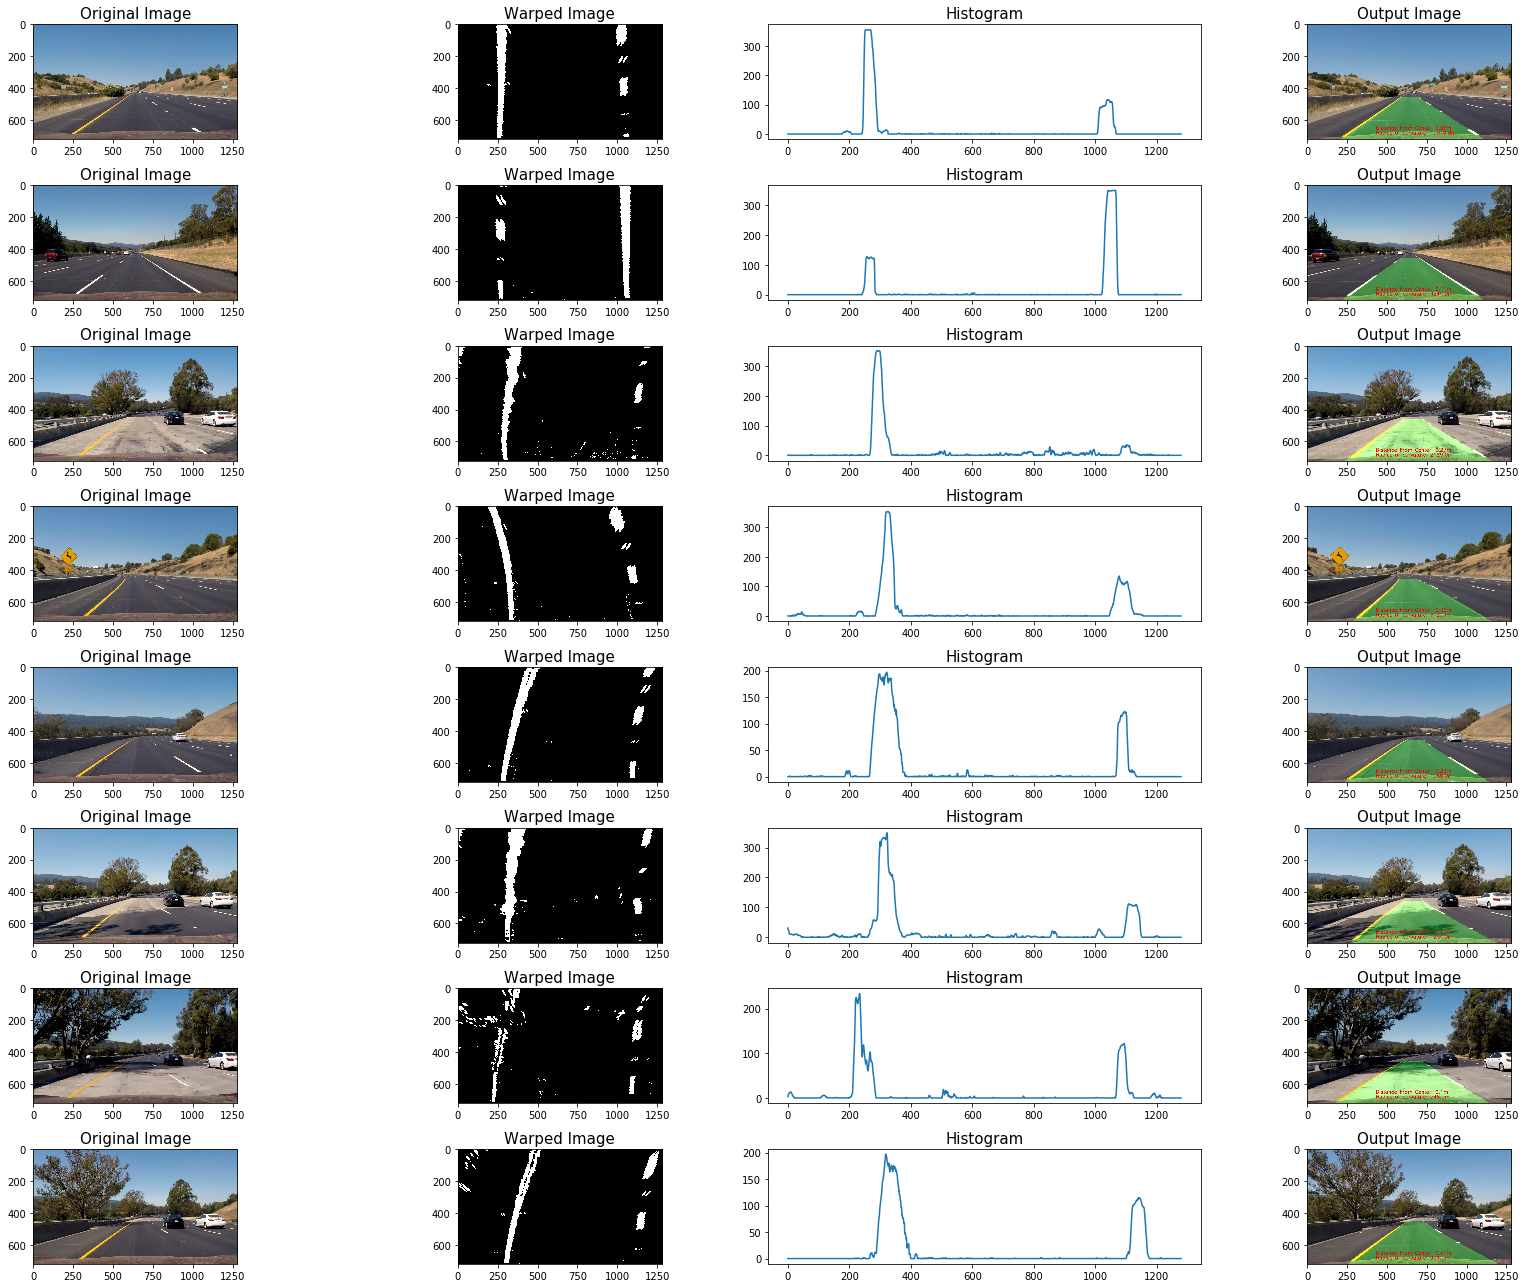

In [67]:
#file_name = 'test_images/test3.jpg'
#file_name = 'camera_cal/test_calibration1.jpg'
#image = mpimg.imread(file_name)
#images = glob.glob('test_images/*.jpg')
import glob
%matplotlib inline

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 253), sx_thresh=(20, 255), v_thresh=(220,255)):
    # Step 1: Camera calibration
    # Step 2: Distortion correction
    undist_output = undistort_road_img(img)
    # Step 3: Color & gradient threshold
    threshold_output = thresh_road_img(undist_output, s_thresh, sx_thresh, v_thresh)   
    # Step 4: Perspective transform 
    warped_output, M = warp_road_img(threshold_output)
    #Step 5: restore image with road marked 
    marked_road_output = mark_road(img, warped_output)
    
    return marked_road_output, warped_output

test_file_names = glob.glob('test_images/*.jpg')

test_img_list = []
warp_img_list = []
out_img_list = []

for test_file_name in test_file_names:
    image = mpimg.imread(test_file_name)
    #image = draw_road_window(image)
    test_img_list.append(image)
    out_image, warp_image = pipeline(image)
    out_img_list.append(out_image)
    warp_img_list.append(warp_image)

# for visualization
draw_figure(test_img_list, out_img_list, warp_img_list, size=(24, 18))

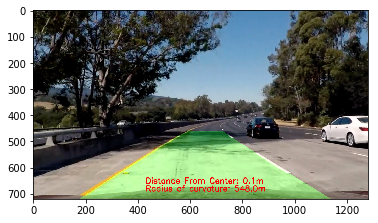

In [68]:
index = 6
img = test_img_list[index]
result, warp = pipeline(img)
plt.imshow(result)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [69]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [70]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    out_image, warp_image = pipeline(image)
    return out_image

Let's try the one with the solid white lane on the right first ...

In [71]:
white_output = './project_video_out1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_video_out1.mp4
[MoviePy] Writing video ./project_video_out1.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:39<00:00,  3.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out1.mp4 

Wall time: 6min 41s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))